In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from utils import *

import warnings
warnings.filterwarnings('ignore')

## Homework Structure

This homework consists of 3 files:
* [hw3_part1](./hw3_part1.ipynb): It contains an analysis for the first part of the homework. The dataset given contains player-referee dyads and therefore each player appears more than once in the dataset. In our first approach, we keep the dataset as it is, i.e. we do not perform any <code>groupby</code> operation. We remove features that add noise to the dataset and achieve an of 77%.
* [hw3_part1_second_approach](./hw3_part1_second_approach.ipynb): It contains an analysis for the first part of the homework with a second approach on the dataset. More concretely, we do perform a <code>groupby</code> operation using the player name. Achieve a very poor accuracy.
* [hw3_part2](./hw3_part2.ipynb): It contains an analysis for the second part of the homework. More concretely, we perform a <code>groupby</code> operation on the player name and investigate if we can build to separate clusters for white and black soccer player. Our analysis shows that this clustering is not successful.

## Data loading

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.shape

(146028, 28)

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


We remove features that are considered to have no impact on the clustering that we are planning to do.

In [4]:
# list of features to drop
drop_features = ['photoID','player', 'position', 'Alpha_3', 'birthday', 'club', 'weight', 'height']
data = data.drop(drop_features, axis=1)
data.shape

(146028, 20)

We remove rows that have <code>NA</code> values in the <code>rater1, rater2</code> columns.

In [5]:
data.dropna(axis=0,subset=['rater1','rater2'], inplace=True)

We search which columns contain <code>NA</code> values.

In [6]:
columns_with_nan = pd.isnull(data).sum() > 0
columns_with_nan = list(columns_with_nan[columns_with_nan].index)
print(columns_with_nan)

['meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']


We fill the missing values with the median of each feature using the <code>fill_nan_values()</code> function from the <code>utils</code> file.

In [7]:
for name in columns_with_nan:
    data[name] = fill_nan_values(data[name])

We convert the <code>leageCountry</code> feature to categorical and then use the respective categorical code for each country.

In [8]:
# convert leageCountry to categorical
data['leagueCountry'] = data['leagueCountry'].astype('category')
# keep categorical columns
cat_cols = data.select_dtypes(['category']).columns
# convert strings into categorical codes
data[cat_cols] = data[cat_cols].apply(lambda col : col.cat.codes) 

Also, we drom the <code>refNum</code> and <code>refCountry</code> attributes, since they are considered to be irrelevant with the clustering task.

In [9]:
referee_features = ['refNum','refCountry']
data = data.drop(referee_features, axis=1)
data.shape

(124621, 18)

## Applied Machine Learning

We start by bulding the **X** and **y** matrices that contain the features and the response respectively.

In [10]:
X = data.drop(['rater1','rater2'], axis=1)

For the skin colour, we consider people with 0, 0.25 and 0.5 labels as white and map them to a new label with value 0. The rest is considered to be black and are mapped to a new label with value 1.

In [11]:
y = data[['playerShort', 'rater1']]
y['rater1'] = y['rater1'].map({0.0:0, 0.25:0, 0.5:0, 0.75:1, 1.0:1})
y = y.groupby('playerShort', as_index=False).mean()
y.head(8)

,playerShort,rater1
0,aaron-hughes,0
1,aaron-hunt,0
2,aaron-lennon,0
3,aaron-ramsey,0
4,abdelhamid-el-kaoutari,0
5,abdou-traore_2,1
6,abdoulaye-diallo_2,1
7,abdoulaye-keita_2,1


**NOTE**: We also tried a mapping of <code>{0.0:0, 0.25:0, 0.5:1, 0.75:1, 1.0:1}</code> but we got worse results

After grouping by soccer player, we drop the <code>playerShort</code> feature in the **y** matrix since it is no longer necessary.

In [12]:
y.drop(['playerShort'], axis=1, inplace=True)

Now, **X** matrix contains two set of features. The first set should be aggregated using the <code>sum</code> function. These features are:
* games	
* victories	
* ties	
* defeats	
* goals	
* yellowCards	
* yellowReds	
* redCards

The meaning of these features indicated that there is no reason to perform an aggragation using the <code>mean()</code> function. We see that these features have an <code>int64</code> type.

In [13]:
X1_columns = X.select_dtypes(['object', 'int64']).columns
X1 = X[X1_columns]
# group and aggregate by sum
X1 = X1.groupby(by='playerShort', as_index=False).sum()

In [14]:
X1.head()

,playerShort,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
0,aaron-hughes,654,247,179,228,9,19,0,0
1,aaron-hunt,336,141,73,122,62,42,0,1
2,aaron-lennon,412,200,97,115,31,11,0,0
3,aaron-ramsey,260,150,42,68,39,31,0,1
4,abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2


The second set of features in the **X** matrix should be aggregated using the <code>mean</code> function. These features are:
* meanIAT	
* nIAT	
* seIAT	
* meanExp	
* nExp 
* seExp

The meaning of these features indicated that there is no reason to perform an aggragation using the <code>sum()</code> function. We see that these features have an <code>float64</code> type.

In [15]:
# we should keep the playerShort features as a key for the inner join (performed later)
names = pd.DataFrame(X['playerShort'])
X2_columns = X.select_dtypes(['float64']).columns
X2 = X[X2_columns]
# join names with X2 (float matrix). Names are used as the join key in future steps
X2 = pd.merge(names, X2, left_index=True, right_index=True)
# group and aggregate by mean
X2 = X2.groupby(by='playerShort', as_index=False).mean()

In [16]:
X2.head()

,playerShort,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,aaron-hughes,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065
1,aaron-hunt,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993
2,aaron-lennon,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032
3,aaron-ramsey,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522
4,abdelhamid-el-kaoutari,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296


Now, we construct the final **X** matrix, that contains the features.

In [17]:
X = pd.merge(X1, X2, how='inner', left_on='playerShort', right_on='playerShort')

In [18]:
X.head()

,playerShort,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,aaron-hughes,654,247,179,228,9,19,0,0,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065
1,aaron-hunt,336,141,73,122,62,42,0,1,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993
2,aaron-lennon,412,200,97,115,31,11,0,0,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032
3,aaron-ramsey,260,150,42,68,39,31,0,1,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522
4,abdelhamid-el-kaoutari,124,41,40,43,1,8,4,2,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296


In [19]:
X.drop('playerShort', inplace=True, axis=1)

## Data Visualization

In [20]:
X.describe()

,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000,1585.000000
mean,235.373502,105.567192,56.214511,73.591798,27.788644,31.384858,0.948265,1.002524,0.348317,16297.957712,0.000608,0.463272,16908.045366,0.002848
std,142.592308,77.571550,34.100482,41.228598,41.517690,25.030628,1.389844,1.338057,0.013437,26764.592701,0.001013,0.095187,27566.989977,0.004606
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.274185,483.666667,0.000010,-0.072948,500.333333,0.000037
25%,131.000000,52.000000,31.000000,43.000000,4.000000,13.000000,0.000000,0.000000,0.338413,3967.865672,0.000221,0.387794,4150.385965,0.000995
50%,213.000000,85.000000,52.000000,69.000000,13.000000,26.000000,0.000000,1.000000,0.346294,7485.852273,0.000321,0.455001,7735.181818,0.001509
75%,322.000000,140.000000,77.000000,98.000000,35.000000,43.000000,1.000000,1.000000,0.357694,22666.782609,0.000582,0.540081,23614.838710,0.002898
max,914.000000,527.000000,197.000000,259.000000,420.000000,197.000000,12.000000,13.000000,0.413096,429801.926829,0.018361,1.122201,441869.926829,0.089830


We perform **PCA** in order to be able to visualize the data. However, normalization is required before performing PCA. We use the <code>StandardScaler</code>. This method normalizes the data with $μ = 0$ and $σ = 1$.

In [21]:
from sklearn import preprocessing

In [22]:
scaler = preprocessing.StandardScaler().fit(X)
# normalize data with μ=0 and σ=1 
X_normalized = scaler.transform(X)  

In [23]:
# convert X_normalized from array to dataframe
X_normalized = pd.DataFrame(X_normalized, columns=X.columns.values)

In [24]:
X_normalized.isnull().values.any()

False

Now, we perform PCA and keep the two important principal components.

In [25]:
from sklearn.decomposition import PCA

In [26]:
# keep 2 principal compoments
pca = PCA(n_components=2)
X_reduced = pca.fit(X_normalized).transform(X_normalized)
X_reduced = pd.DataFrame(X_reduced, columns=['comp1', 'comp2'])
X_reduced.head()

,comp1,comp2
0,4.471090,0.499914
1,1.425652,0.055812
2,1.387547,0.186248
3,0.233261,2.359496
4,-1.167183,1.256295


We find the variance of the data explained using the first 2 principal components.

In [27]:
print('Explained variance ratio (first two components): %s'% str(pca.explained_variance_ratio_))

Explained variance ratio (first two components): [ 0.3447504   0.17620607]


We aggregate the 2 principal components and the labels into one dataframe to ease visualization.

In [28]:
aggregated_data = pd.merge(X_reduced, y, left_index=True, right_index=True)
aggregated_data.head(7)

,comp1,comp2,rater1
0,4.471090,0.499914,0
1,1.425652,0.055812,0
2,1.387547,0.186248,0
3,0.233261,2.359496,0
4,-1.167183,1.256295,0
5,-2.292132,2.949087,1
6,-3.455438,0.079138,1


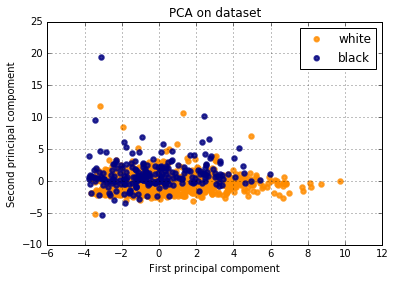

In [29]:
visualize_pca(aggregated_data)

We see that it is very difficult to define two different clusters even after using PCA. We proceed with the clustering analysis using k-means.

## Clustering Analysis

In [30]:
from sklearn.cluster import KMeans
from sklearn import metrics

First, we plot the distribution of each feature to see if our dataset contains outliers.

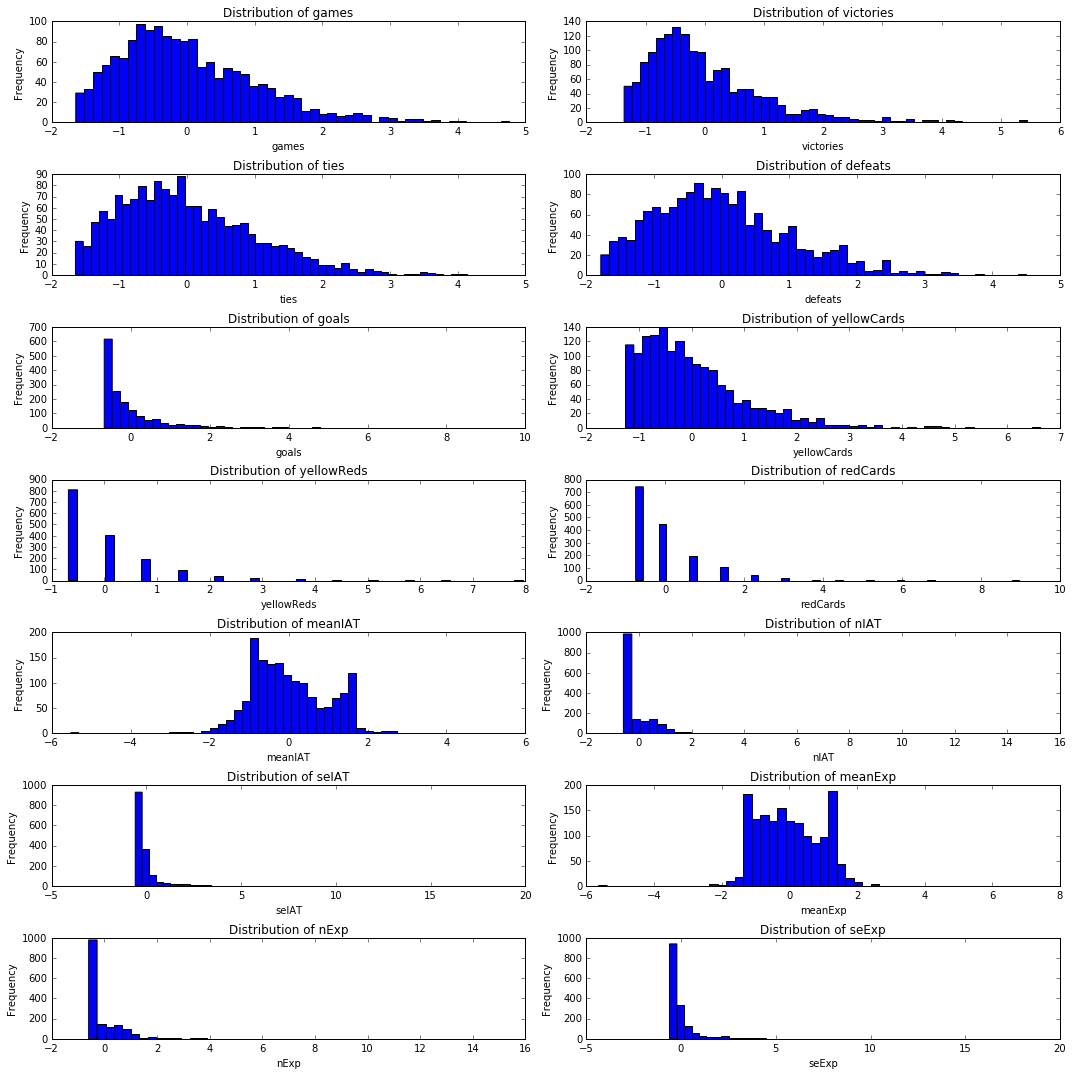

In [31]:
plot_hist_of_features(X_normalized)

Some features contain outliers, that should be removed.

### Outliers

We remove the outliers of the dataset.

In [32]:
# remove outlierf from dataset
y_new, x_new = detect_outliers(X_normalized, y)

In [33]:
# rename variables
X = x_new
y = y_new

In [34]:
features = X.columns.values

### Forward Feature Selection

We perform forward feature selection using a greedy algorithm. We start using a null model (i.e. no predictors) and add the predictor that gives the greatest additional improvement. In the second round, we iterate through all remaining predictors and add the one that again gives the greatest additional improvement and so forth. We repeat this procedure k times, where k is the total number of features.

In [35]:
ffs = forward_feature_selection(X)

---------------------------------------------------------
Clustering with 1 feature(s)
Best feature combination:
 	 redCards
Silhouette score:  0.880393996248 

---------------------------------------------------------
Clustering with 2 feature(s)
Best feature combination:
 	 redCards, seIAT
Silhouette score:  0.734492632706 

---------------------------------------------------------
Clustering with 3 feature(s)
Best feature combination:
 	 redCards, seIAT, seExp
Silhouette score:  0.620826281583 

---------------------------------------------------------
Clustering with 4 feature(s)
Best feature combination:
 	 redCards, seIAT, seExp, meanExp
Silhouette score:  0.536345240859 

---------------------------------------------------------
Clustering with 5 feature(s)
Best feature combination:
 	 redCards, seIAT, seExp, meanExp, meanIAT
Silhouette score:  0.608888692594 

---------------------------------------------------------
Clustering with 6 feature(s)
Best feature combination:
 	 red

We see that the more features we add, the worst score we get. This means that our data are really noisy and extra features do not help in building two separate clusters.

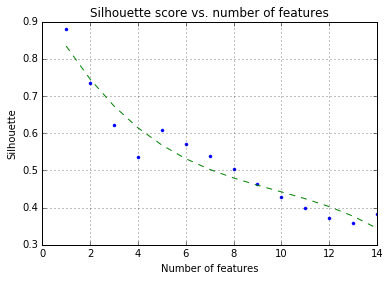

In [36]:
visualize_silhouette_score(ffs)

### Backward Feature Selection

It is the opposite of forward stepwise selection. We start using the full set of predictors and removing the least useful predictor, one-at-a-time.

In [37]:
bfs = backward_feature_selection(X)

---------------------------------------------------------
Clustering with 13 feature(s)
Best feature combination:
 	 games, victories, ties, defeats, goals, yellowCards, yellowReds, redCards, nIAT, seIAT, meanExp, nExp, seExp
Silhouette score:  0.420667351956 

---------------------------------------------------------
Clustering with 12 feature(s)
Best feature combination:
 	 games, victories, ties, defeats, goals, yellowCards, yellowReds, redCards, nIAT, seIAT, nExp, seExp
Silhouette score:  0.470380700573 

---------------------------------------------------------
Clustering with 11 feature(s)
Best feature combination:
 	 games, victories, ties, defeats, goals, yellowCards, redCards, nIAT, seIAT, nExp, seExp
Silhouette score:  0.493685912145 

---------------------------------------------------------
Clustering with 10 feature(s)
Best feature combination:
 	 games, victories, ties, defeats, goals, yellowCards, nIAT, seIAT, nExp, seExp
Silhouette score:  0.511884510822 

-------------

We see that we got different results from the forward feature selection. We keep <code>[games, ties]</code> as best feature combination since both <code>games, ties</code> are continuous variables (compared to the <code>[redCards, seIAT]</code> of the forward feature selection). 

## Clustering in labeled dataset

Kmeans is an unsupervised technique used for clustering. However, some datasets, like the one provided, that labeled data. In such cases, we can perform the clustering and use the labels in the visualization part, in order to see if the data classes can be separated with Kmeans. 

In [38]:
y_df = pd.DataFrame(y)
data = pd.merge(y_df, X, left_index=True, right_index=True)

<a name="real-visualization"></a>

### Real Data Vizualization

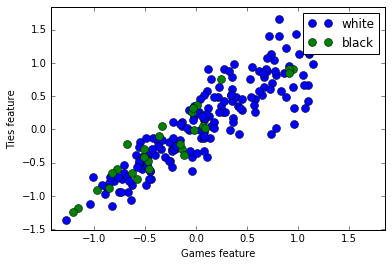

In [39]:
groups = data.groupby('rater1')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
labels = ['white', 'black']
label_id = 0
for name, group in groups:
    ax.plot(group.games, group.ties, marker='o', linestyle='', ms=8, label=labels[label_id])
    plt.xlabel('Games feature')
    plt.ylabel('Ties feature')
    label_id += 1
ax.legend()
plt.show()

After PCA, this is a second evidence that the data cannot be splitted properly in two clusters, where the one cluster represents white and the second cluster black soccer players.

## K-means with the 2 most importand features

We keep the two most important features given by the forward feature selection

In [40]:
important_features = ['games', 'ties']

In [41]:
# number of clusters
n_clusters = 2
# initialize kmeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X[important_features])
# compute score
silhouette_score = metrics.silhouette_score(X[important_features], kmeans.labels_, metric='sqeuclidean')
silhouette_score

0.72190065418487848

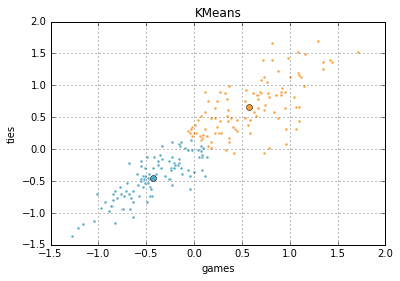

In [42]:
visualize_clusters(kmeans, X[important_features], important_features,  n_clusters)

**NOTE:** Here, the colours represent the cluster in which a data point belongs to. They have nothing to do with the skin colour of the player.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2 The average silhouette_score is : 0.54058228002


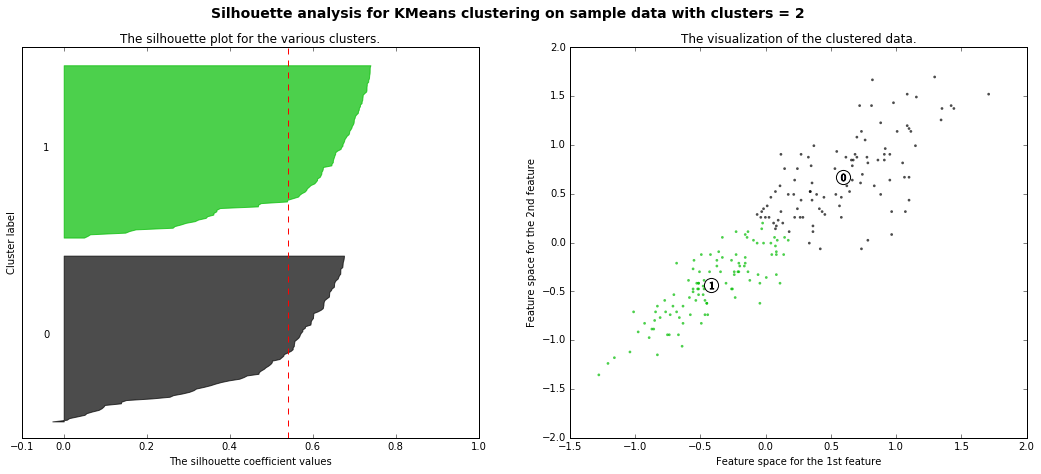

In [43]:
silhouette_analysis(X[important_features])

### Gaussian Mixture Model

Also we perform clustering using Gaussian Mixture Models. A quick introduction to GMMs can be found [here](http://www.nehalemlabs.net/prototype/blog/2014/04/03/quick-introduction-to-gaussian-mixture-models-with-python/). This type of model performs soft clustering, as it assigns each data point to a cluster with certain probability. The cluster may have elliptic or shperical shapes.

In [44]:
from sklearn import mixture
gmix = mixture.GMM(n_components=2, covariance_type='full')
gmix.fit(X[important_features])

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  tol=0.001, verbose=0)

The centers of the cluster are:

In [45]:
print(gmix.means_)

[[ 0.57459779  0.61452789]
 [-0.35609109 -0.33691101]]


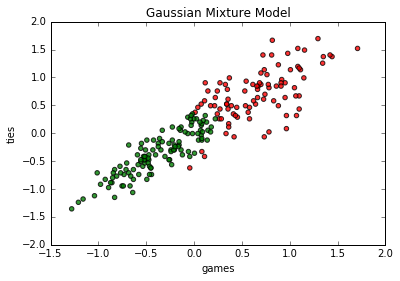

In [46]:
plot_gmm(gmix, X[important_features], important_features)

In [47]:
metrics.silhouette_score(X[important_features], gmix.predict(X[important_features]), metric='euclidean')

0.51442445807132009

We indentify two clusters, slightly different than Kmeans. However, these clusteres do not represent the [real](#real-visualization) distribution of white and black soccer players.